<p align="center">
<img src="Presentation/Images/header.jpg" width=1000px>
</p>

# Flatiron Studio
## Overview

Our company, Microwave Ovens and More, is venturing into film making.  When Amazon and Apple started distributing films, they turned to established movie studios to produce their films.  Given the talent and expertise at these studios, it would make sense to follow a similar path.  To support this, this data analysis explored the business side of large American movie studios and found these key insights:

1. Even **lower-budget** films produced for **under $12 million** can turn a **profit**.
2. **Universal Pictures**, **Columbia Pictures**, and **Paramount Studios** have been the most financially successful with these lower-budget films.  
3. These three studios have produced many profitable, well-reviewed **comedies** and **dramas** at these lower-budgets.



## Business Problem
This data analysis sought to understand the financial side of major American studios in order to evaluate a potential partnership with them.  It looked to answer these three questions:  
1. What are the typical range of production budgets for a movie at a major studio, and what size return on investment could be expected?
2. Which studios are financially successful in our budget-range?  
3. What genre of movie have these studios been successful with?  

Two metrics have been used to measure movie success:
- **Return on Investment**: movie profit/movie budget
- **Percent Fresh**: the fraction of good reviews given to a movie, as compiled by Rotten Tomatoes





## Data Understanding  
The data was drawn from a TMDB Dataset of 1 million records details movies released from the 1930s to 2024.  The data was collected by [The Movie Database](http://tmdb.org) and posted to [Kaggle](https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies).   

## Data Preparation
These were the key features used from the TMDB dataset:
- Release Date
- Movie Title
- Production Budget
- Revenue
- Production Company
- Genre
- Production Country

From Rotten Tomatoes:
- Freshness Rating for each review
- Box Office Returns

### Drop NaN Values and Fix Production Companies/Genres
First, import the TMDB dataset, and drop rows missing budget, revenue, and production company data.  Also, drop films with budgets below $100,000, as this is probably errant data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
df = pd.read_csv("Data_API/TMDB_movie_dataset_v11.csv")

In [3]:
df = df.dropna(subset=["budget","revenue", "production_companies"])
df = df[df["budget"] > 100000]

### Adjust for inflation
Adjust movie budgets and revenues for inflation, assuming 2% yearly inflation.

In [4]:
df = df.dropna(subset=["release_date"])
df["inf_multiplier"] = 1.02**(2024-df["release_date"].str.slice(0,4).astype(int))
df["budget"] = df["budget"] * df["inf_multiplier"]
df["revenue"] = df["revenue"] * df["inf_multiplier"]

### Fix Production Companies, Genre, and Regions
Some features list multiple values in each cell.  To fix this, create a new entry for each unique value.

In [5]:
df["production_companies"] = df["production_companies"].str.split(",")
df = df.explode("production_companies")
df["production_companies"] = df["production_companies"].str.strip()

In [6]:
df["genres"] = df["genres"].str.split(",")
df = df.explode("genres")
df["genres"] = df["genres"].str.strip()

In [7]:
df["production_countries"] = df["production_countries"].str.split(",")
df = df.explode("production_countries")
df["production_countries"] = df["production_countries"].str.strip()

## Feature Engineering:
### Calculate ROI
Calculate the return on investment using: 
$\frac{revenue-budget}{budget}$

In [8]:
df["roi"] = (df["revenue"] - df["budget"])/df["budget"]

### Create List of Top American Studios
Create a list of American movie studios that have released 50 or more movies.

In [9]:
df = df[df["production_countries"] == "United States of America"]
unique_movies = df.drop_duplicates(subset=["title", "production_companies"])
unique_movies = unique_movies.groupby("production_companies").count().sort_values("id", ascending=False)
top_studios = unique_movies.loc[unique_movies["id"] >= 50].index

### Filter Movies for Major Studios
Drop entries from the dataset for movies not produced by a studio in our top studios list.

In [10]:
df = df[df["production_companies"].isin(top_studios)]

In [11]:
df = df[["title", "budget", "revenue", "genres", "production_companies", "roi"]]

### Get Rotten Tomatoes Data
Load our Rotten Tomatoes datasets.

In [12]:
rt1 = pd.read_csv("Data/rt.movie_info.tsv",delimiter="\t")
rt2 = pd.read_csv("Data/rt.reviews.tsv", delimiter="\t", encoding='windows-1252')

## Analyze Data
### Visualization 1: Production Budgets and ROIs at Top Studios

The top American movie studios produce films with budgets from just a few hundred thousand dollars to hundreds of millions of dollars.  In the graphs below, we see that the films costing **less that $12 million** are well represented.  Half of these films turn a profit.  For our first forays into movie making, producing a film with a budget under $12 million makes sense.

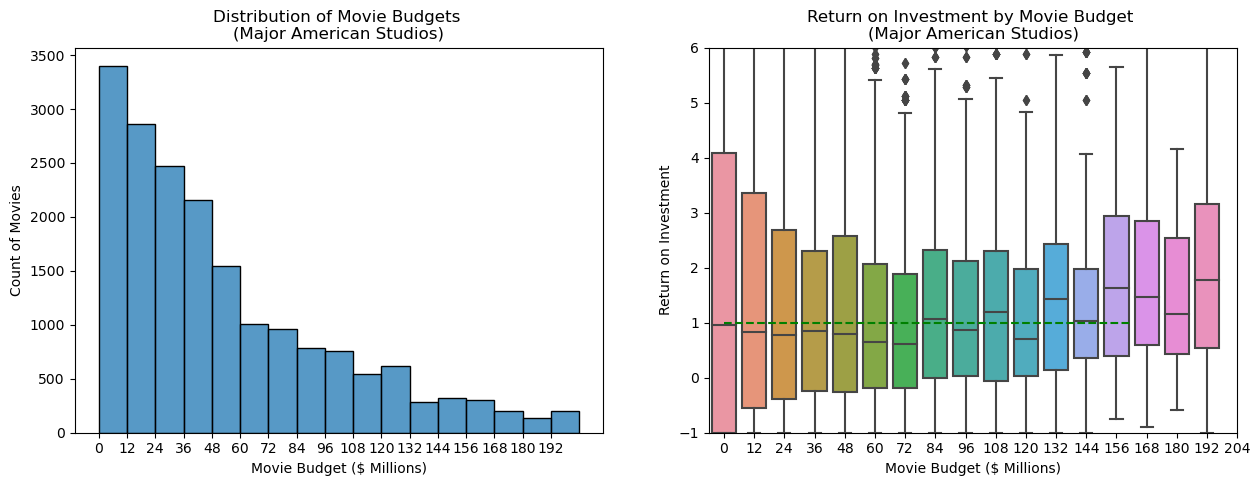

In [13]:
fig, ax = plt.subplots(1,2, figsize=[15, 5])
sns.histplot(data=df, x="budget", bins=np.arange(0,210000000,12000000), ax=ax[0])
ax[0].set_title("Distribution of Movie Budgets \n(Major American Studios)")
ax[0].set_xlabel("Movie Budget ($ Millions)")
ax[0].set_ylabel("Count of Movies")

tick_labels = [str(x) for x in np.arange(0,194,12)]
ax[0].set_xticks(np.arange(0,200000000, 12000000), labels=tick_labels)



df["budget_bin"] = (df["budget"] // 12000000 + 1) * 12000000 
sns.boxplot( data=df[df["budget"]<200000000], x="budget_bin", y="roi", ax=ax[1])
ax[1].set_ylim(-1, 6)
ax[1].hlines(y=1, xmin=0, xmax=13.5, color="g", linestyles="dashed" );

ax[1].set_title("Return on Investment by Movie Budget \n(Major American Studios)")
ax[1].set_xlabel("Movie Budget ($ Millions)")
ax[1].set_ylabel("Return on Investment")
ticks = [x for x in np.arange(0,18,1)]
len(ticks)
tick_labels = [str(x) for x in np.arange(0,205,12)]
ax[1].set_xticks(ticks, labels=tick_labels)

fig.savefig("Presentation/Images/overview_studios.png", bbox_inches="tight")


### Visualization 2: Top Studios for Lower-Budget Films
For films costing less than $12 million, we see that **Paramount Pictures**, **Columbia Pictures**, and **Universal Studios** have the highest ROIs.

Index(['Paramount', 'Warner Bros. Pictures', 'Universal Pictures'], dtype='object', name='production_companies')

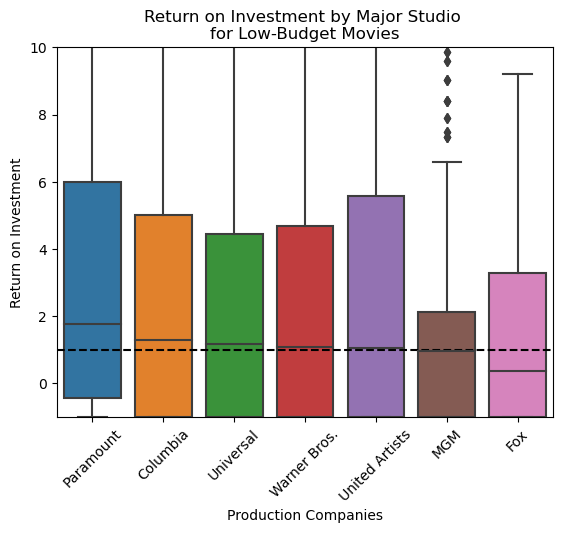

In [14]:
df_low_budget = df[df["budget"] < 15000000]
df_low_budget = df_low_budget.groupby("production_companies").count()
studio_low_budget = list(df_low_budget[df_low_budget["roi"] > 200].index)

temp = df.loc[(df["budget"] < 15000000) & (df["production_companies"].isin(studio_low_budget)), ["production_companies","roi"]]
studios_ordered = temp.groupby("production_companies").median().sort_values("roi", ascending=False).index

fig, ax = plt.subplots()
sns.boxplot(data=temp, x="production_companies", y="roi", order=studios_ordered, ax=ax)
ax.hlines(y=1.0, xmin=-0.5, xmax=6.5, color="black", linestyles="dashed")
ax.set_ylim(-1, 10)
ax.set_xlabel("Production Companies")
ax.set_ylabel("Return on Investment")
ax.set_title("Return on Investment by Major Studio \nfor Low-Budget Movies")

ax.set_xticklabels(["Paramount", "Columbia", "Universal", "Warner Bros.", "United Artists", "MGM", "Fox"])
ax.tick_params("x", labelrotation=45)

fig.savefig("Presentation/Images/roi_studio_low_budget.png", bbox_inches="tight")

target_studios = studios_ordered[:3]
target_studios

### Visualization 3: Successful Genres For Low-Budget Films at Our Target Studios

A majority of the profitable films with budgets under $12 million at these three studios are either a **comedy** or **drama**.

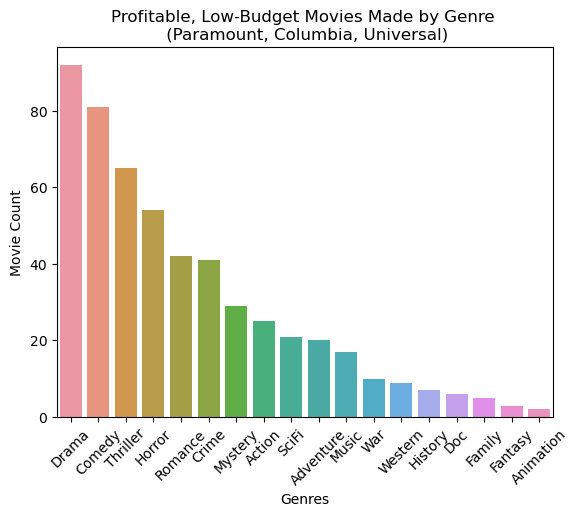

In [15]:
df_low_budget2 = df[df["budget"] < 15000000]
genres_count_successful = df_low_budget2.loc[(df_low_budget2["production_companies"].isin(target_studios)) & (df_low_budget2["roi"] > 1),"genres"].value_counts()

genres = list(genres_count_successful.index)
genres[8] = "SciFi"
genres[-4] = "Doc"

fig, ax = plt.subplots()
sns.barplot(x=genres, y=genres_count_successful.values, ax=ax)
ax.tick_params("x", labelrotation=45)
ax.set_xlabel("Genres")
ax.set_ylabel("Movie Count")
ax.set_title("Profitable, Low-Budget Movies Made by Genre \n (Paramount, Columbia, Universal)")
fig.savefig("Presentation/Images/genre_distribution_lowbudget.png", bbox_inches="tight")

target_genres = ["Drama", "Comedy"]

### Visualization 4: How are quality and profit related?
Paramount, Columbia, and Universal comedy and drama films have a low-correlation between quality and revenue.  Here the average freshness score assigned by Rotten Tomatoes is a proxy for quality, and box-office is our revenue

In [16]:
rt1 = rt1[rt1["studio"].isin(target_studios)]
rt1 = rt1.dropna(subset="box_office")
rt1["box_office"] = rt1["box_office"].str.replace(",","").astype(float)

In [17]:
rt2["fresh_bool"] = rt2["fresh"] == "fresh"
rt2 = rt2[["id", "fresh_bool"]].groupby("id").mean()
box_office_fresh = rt1[["id","box_office"]].merge(rt2, left_on="id", right_on="id")

                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     3.547
Date:                Fri, 04 Oct 2024   Prob (F-statistic):             0.0673
Time:                        13:46:51   Log-Likelihood:                -777.60
No. Observations:                  40   AIC:                             1559.
Df Residuals:                      38   BIC:                             1563.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.156e+07   2.23e+07      1.418      0.1

,fresh_bool,box_office
fresh_bool,1.000000,0.292205
box_office,0.292205,1.000000


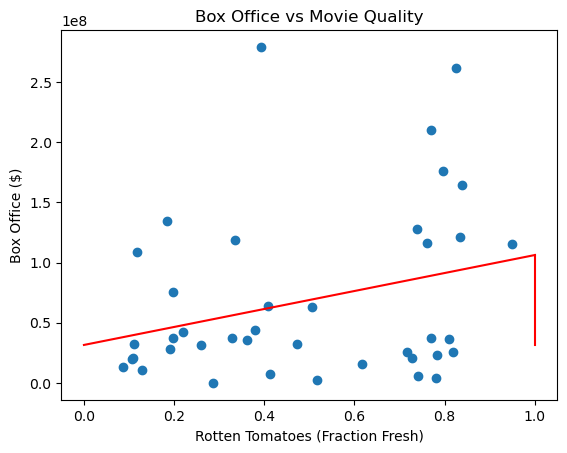

In [18]:
model = sm.regression.linear_model.OLS(endog=box_office_fresh["box_office"], exog=sm.add_constant(box_office_fresh["fresh_bool"]))
results = model.fit()
print(results.summary())

x = sm.add_constant(np.linspace(0,1) )
y_predict = results.predict(x)

fig, ax = plt.subplots()
ax.scatter(x=box_office_fresh["fresh_bool"], y=box_office_fresh["box_office"])
ax.plot(x, y_predict, color="r")
ax.set_xlabel("Rotten Tomatoes (Fraction Fresh)")
ax.set_ylabel("Box Office ($)")
ax.set_title("Box Office vs Movie Quality")

fig.savefig("Presentation/Images/freshBool_boxOffice.png", bbox_inches="tight")

box_office_fresh[["fresh_bool", "box_office"]].corr()

## Conclusions
1. **Lower-budget** films produced for **under $12 million** can turn a **profit**.
2. **Universal Pictures**, **Columbia Pictures**, and **Paramount Studios** have been the most financially successful with these lower-budget films.  
3. These three studios have produced many profitable, well-reviewed **comedies** and **dramas** at these lower-budgets.

## Next Steps
- Complete statistical significance tests to see if our target studios are likely to be different from the other American studios.
- Research other companies experience with investments in the film industry